<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">

# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Alumno: Mauro Fabián Barquinero

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.

#### Carga del corpus

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
import math
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [2]:
# Paso 1: Cargar el corpus
with open("dataset/quijote.txt", "r", encoding="utf-8") as file:
    texto = file.read()

# Mostrar un fragmento del corpus
print(texto[:1000])  # Muestra los primeros 1000 caracteres
print(f"\nCantidad total de caracteres: {len(texto)}")

En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua,
rocín flaco y galgo corredor. Una olla de algo más vaca que carnero,
salpicón las más noches, duelos y quebrantos los sábados, lantejas los
viernes, algún palomino de añadidura los domingos, consumían las tres
partes de su hacienda. El resto della concluían sayo de velarte, calzas de
velludo para las fiestas, con sus pantuflos de lo mesmo, y los días de
entresemana se honraba con su vellorí de lo más fino. Tenía en su casa una
ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte,
y un mozo de campo y plaza, que así ensillaba el rocín como tomaba la
podadera. Frisaba la edad de nuestro hidalgo con los cincuenta años; era de
complexión recia, seco de carnes, enjuto de rostro, gran madrugador y amigo
de la caza. Quieren decir que tenía el sobrenombre de Quijada, o Quesada,
que en esto hay alguna diferencia en los autores q

#### Limpieza y normalización del texto

In [3]:
# Normalización del texto
texto = texto.lower()
print(texto[:1000])

en un lugar de la mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua,
rocín flaco y galgo corredor. una olla de algo más vaca que carnero,
salpicón las más noches, duelos y quebrantos los sábados, lantejas los
viernes, algún palomino de añadidura los domingos, consumían las tres
partes de su hacienda. el resto della concluían sayo de velarte, calzas de
velludo para las fiestas, con sus pantuflos de lo mesmo, y los días de
entresemana se honraba con su vellorí de lo más fino. tenía en su casa una
ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte,
y un mozo de campo y plaza, que así ensillaba el rocín como tomaba la
podadera. frisaba la edad de nuestro hidalgo con los cincuenta años; era de
complexión recia, seco de carnes, enjuto de rostro, gran madrugador y amigo
de la caza. quieren decir que tenía el sobrenombre de quijada, o quesada,
que en esto hay alguna diferencia en los autores q

#### Tokenización por caracteres

In [4]:
# Vocabulario de caracteres
chars = sorted(set(texto))
print(f"Cantidad de caracteres únicos: {len(chars)}")
print(f"Caracteres únicos:\n{chars}")

Cantidad de caracteres únicos: 61
Caracteres únicos:
['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', ':', ';', '?', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '«', '»', '¿', 'à', 'á', 'é', 'í', 'ï', 'ñ', 'ó', 'ù', 'ú', 'ü']


#### Diccionarios índice-carácter

In [ ]:
# Mapas carácter  - índice e índice - carácter
char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for i, ch in enumerate(chars)}

#### Conversión del texto a índices

In [6]:
# Codificar todo el texto a enteros
encoded_text = [char2idx[ch] for ch in texto]
print(f"Primeros 20 índices del texto codificado:\n{encoded_text[:20]}")

Primeros 20 índices del texto codificado:
[26, 34, 1, 41, 34, 1, 32, 41, 28, 22, 38, 1, 25, 26, 1, 32, 22, 1, 33, 22]


### Crear secuencias X, y

In [ ]:
seq_length = 100  # longitud de secuencia
step = 1          # paso de la ventana deslizante

X = []
y = []

for i in range(0, len(encoded_text) - seq_length, step):
    X.append(encoded_text[i:i + seq_length])
    y.append(encoded_text[i + seq_length])

X = np.array(X)
y = np.array(y)

print(f"Cantidad de secuencias generadas: {X.shape[0]}")
print(f"Forma de X: {X.shape}, Forma de y: {y.shape}")

Cantidad de secuencias generadas: 2070988
Forma de X: (2070988, 100), Forma de y: (2070988,)


#### División en entrenamiento y validación

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"Entrenamiento: {X_train.shape}, Validación: {X_val.shape}")

Entrenamiento: (1863889, 100), Validación: (207099, 100)


#### Se guardan los índices

In [ ]:
# Guardar char2idx e idx2char para usar en generación
with open("char2idx.pkl", "wb") as f:
    pickle.dump(char2idx, f)

with open("idx2char.pkl", "wb") as f:
    pickle.dump(idx2char, f)

----

### ARQUITECTURAS

In [ ]:
# Codificar la salida como one-hot
y_train_cat = to_categorical(y_train, num_classes=len(char2idx))
y_val_cat = to_categorical(y_val, num_classes=len(char2idx))

# Definir callback de perplejidad
class PerplexityCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        ce = logs.get("val_loss")
        ppl = math.exp(ce) if ce is not None else float("inf")
        print(f"Perplejidad (val): {ppl:.4f}")


print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.15.0
[]


In [ ]:
# Modelo 1 – SimpleRNN
def build_simplernn_model():
    model = Sequential([
        Embedding(input_dim=len(char2idx), output_dim=64, input_length=seq_length),
        SimpleRNN(128),
        Dense(len(char2idx), activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    return model

rnn_model = build_simplernn_model()
rnn_model.summary()

# Entrenamiento
history_rnn = rnn_model.fit(X_train, y_train_cat,
                            validation_data=(X_val, y_val_cat),
                            batch_size=128,
                            epochs=20,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                                       PerplexityCallback()])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           3904      
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               24704     
                                                                 
 dense (Dense)               (None, 61)                7869      
                                                                 
Total params: 36477 (142.49 KB)
Trainable params: 36477 (142.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20


14562/14562 [==============================] - 166s 11ms/step - loss: 1.7763 - accuracy: 0.4554 - val_loss: 1.6157 - val_accuracy: 0.5018
Epoch 2/20
14562/14562 [==============================] - 171s 12ms/step - loss: 1.5647 - accuracy: 0.5155 - val_loss: 1.5461 - va

In [12]:
# Modelo 2 – LSTM
def build_lstm_model():
    model = Sequential([
        Embedding(input_dim=len(char2idx), output_dim=64, input_length=seq_length),
        LSTM(128),
        Dense(len(char2idx), activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    return model

lstm_model = build_lstm_model()
lstm_model.summary()

# Entrenamiento
history_lstm = lstm_model.fit(X_train, y_train_cat,
                              validation_data=(X_val, y_val_cat),
                              batch_size=128,
                              epochs=20,
                              callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                                         PerplexityCallback()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 64)           3904      
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense_1 (Dense)             (None, 61)                7869      
                                                                 
Total params: 110589 (431.99 KB)
Trainable params: 110589 (431.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
14562/14562 [==============================] - 663s 46ms/step - loss: 1.8382 - accuracy: 0.4363 - val_loss: 1.6104 - val_accuracy: 0.5036
Epoch 2/20
14562/14562 [==============================] - 616s 42ms/step - loss: 1.5309 - accuracy: 0.5253 - val_loss: 1.4857 - v

In [13]:
# Modelo 3 – GRU
def build_gru_model():
    model = Sequential([
        Embedding(input_dim=len(char2idx), output_dim=64, input_length=seq_length),
        GRU(128),
        Dense(len(char2idx), activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    return model

gru_model = build_gru_model()
gru_model.summary()

# Entrenamiento
history_gru = gru_model.fit(X_train, y_train_cat,
                            validation_data=(X_val, y_val_cat),
                            batch_size=128,
                            epochs=20,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                                       PerplexityCallback()])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 64)           3904      
                                                                 
 gru (GRU)                   (None, 128)               74496     
                                                                 
 dense_2 (Dense)             (None, 61)                7869      
                                                                 
Total params: 86269 (336.99 KB)
Trainable params: 86269 (336.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
14562/14562 [==============================] - 551s 38ms/step - loss: 1.7070 - accuracy: 0.4757 - val_loss: 1.5051 - val_accuracy: 0.5350
Epoch 2/20
14562/14562 [==============================] - 567s 39ms/step - loss: 1.4580 - accuracy: 0.5470 - val_loss: 1.4376 - val

In [ ]:
class PerplexityCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        ce = logs.get("val_loss")
        ppl = math.exp(ce) if ce is not None else float("inf")
        print(f" Perplejidad (val): {ppl:.4f}")

In [ ]:
def compute_perplexity(losses):
    return [math.exp(l) for l in losses]

#### Graficar curvas de pérdida (loss + val_loss)

In [16]:
def plot_losses(histories, labels):
    plt.figure(figsize=(10,6))
    for history, label in zip(histories, labels):
        plt.plot(history.history['loss'], label=f'{label} - Train Loss')
        plt.plot(history.history['val_loss'], label=f'{label} - Val Loss', linestyle='--')
    
    plt.title('Evolución de la pérdida por época')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Graficar curvas de perplejidad en validación

In [17]:
def plot_perplexities(histories, labels):
    plt.figure(figsize=(10,6))
    for history, label in zip(histories, labels):
        val_losses = history.history['val_loss']
        val_ppl = compute_perplexity(val_losses)
        plt.plot(val_ppl, label=f'{label} - Val Perplexity')
    
    plt.title('Perplejidad en validación por época')
    plt.xlabel('Épocas')
    plt.ylabel('Perplejidad')
    plt.legend()
    plt.grid(True)
    plt.show()

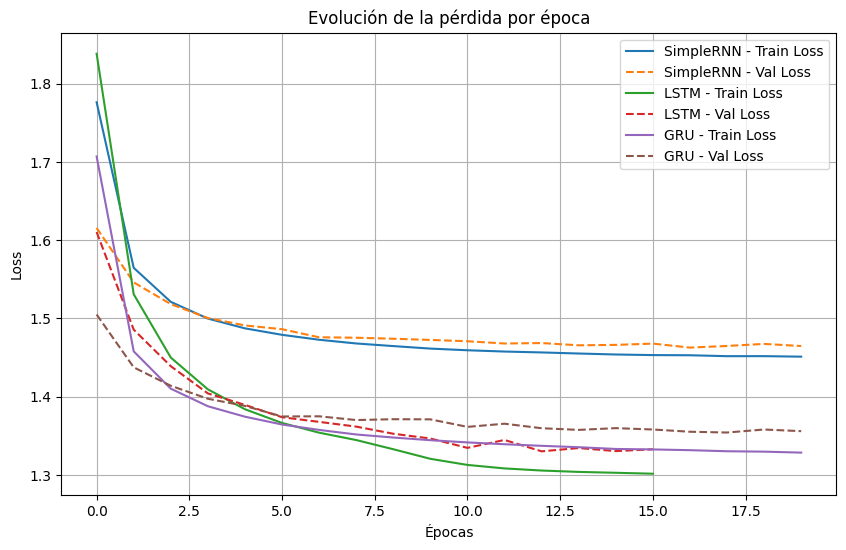

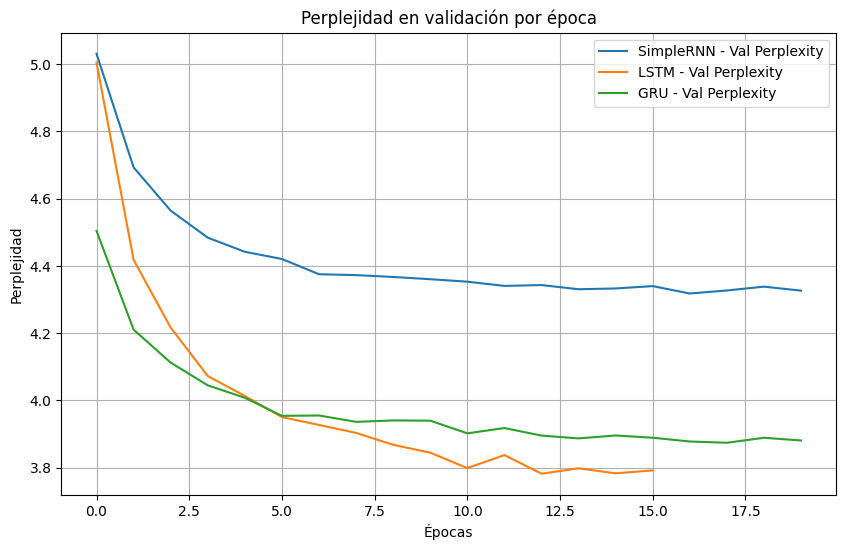

In [18]:
histories = [history_rnn, history_lstm, history_gru]
labels = ["SimpleRNN", "LSTM", "GRU"]

# Gráficas
plot_losses(histories, labels)
plot_perplexities(histories, labels)


## Análisis de resultados

### 1. Evolución de la pérdida (`loss`)

- **SimpleRNN** mostró una convergencia más lenta y una menor capacidad de reducción de la pérdida tanto en entrenamiento como en validación.
- **LSTM y GRU** demostraron una mayor capacidad de modelado secuencial, con pérdidas finales más bajas.
- La pérdida de validación fue más estable y baja en los modelos con memoria (LSTM/GRU), indicando mejor generalización.

### 2. Perplejidad

- La **perplejidad en validación** se redujo significativamente en los tres modelos.
- **LSTM** alcanzó la **perplejidad más baja** (~3.77), seguido de cerca por **GRU** (~3.87), mientras que **SimpleRNN** se mantuvo por encima de 4.3.
- Estos resultados reflejan una mayor capacidad de **LSTM y GRU** para modelar dependencias de largo plazo en el lenguaje.


In [19]:
# Diccionarios útiles
idx2char = {idx: char for char, idx in char2idx.items()}

# Función para convertir un string a secuencia de índices
def text_to_seq(text, char2idx):
    return [char2idx.get(c, 0) for c in text]

# Función para convertir secuencia de índices a string
def seq_to_text(seq, idx2char):
    return ''.join([idx2char[i] for i in seq])

#### Greedy Search

In [20]:
def generate_greedy(model, seed_text, gen_length=200):
    input_seq = text_to_seq(seed_text[-seq_length:], char2idx)
    generated = seed_text

    for _ in range(gen_length):
        padded_input = tf.keras.preprocessing.sequence.pad_sequences([input_seq], maxlen=seq_length)
        pred = model.predict(padded_input, verbose=0)[0]
        next_char_idx = np.argmax(pred)
        next_char = idx2char[next_char_idx]
        generated += next_char
        input_seq = input_seq[1:] + [next_char_idx]

    return generated

In [21]:
print(generate_greedy(lstm_model, seed_text="En un lugar de la Mancha", gen_length=300))

En un lugar de la Manchar esto, señor don quijote del mundo, señor don quijote que se levantaba esto es esto, señor ver el cura es el cura esto es esto, señor ver el cura es el cura esto es esto, señor ver el cura es el cura esto es esto, señor ver el cura es el cura esto es esto, señor ver el cura es el cura esto es esto,


### Análisis
- El texto es gramaticalmente correcto, pero muestra un alto nivel de repetición.
- La falta de exploración en los siguientes caracteres lleva al modelo a caer en bucles cortos y reiterativos (e.g., "esto es esto", "el cura es el cura").
- Esto es típico de greedy search, debido a que siempre elige el carácter más probable, sin explorar variaciones.

#### Sampling estocástico con temperatura

In [22]:
def sample_with_temperature(preds, temperature=1.0):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds + 1e-10) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(preds), p=preds)

def generate_with_temperature(model, seed_text, gen_length=200, temperature=1.0):
    input_seq = text_to_seq(seed_text[-seq_length:], char2idx)
    generated = seed_text

    for _ in range(gen_length):
        padded_input = tf.keras.preprocessing.sequence.pad_sequences([input_seq], maxlen=seq_length)
        preds = model.predict(padded_input, verbose=0)[0]
        next_char_idx = sample_with_temperature(preds, temperature)
        next_char = idx2char[next_char_idx]
        generated += next_char
        input_seq = input_seq[1:] + [next_char_idx]

    return generated

In [23]:
print(generate_with_temperature(lstm_model, seed_text="En un lugar de la Mancha", gen_length=300, temperature=0.5))
print(generate_with_temperature(lstm_model, seed_text="En un lugar de la Mancha", gen_length=300, temperature=1.0))
print(generate_with_temperature(lstm_model, seed_text="En un lugar de la Mancha", gen_length=300, temperature=1.5))

En un lugar de la Manchar es pedir bien esta de todos lo que lo dejaría me habéis prestos estoy buena fuerza me quedaron sancho, es tener
esta amigo maravilla, señor don quijote don quijote se ha siendo en ahora lo es esto respondió la alcanza sancho, esto replicó
sancho, pues, sancho antes por señala, señor ver a su prome
En un lugar de la Mancha y no quiera que los del tus burno, movido es uequese es el prometer fuera respondió quiero quiero vellería su contario, señor roto, señor, abo campo dos maldiciesa, sancho, no es digo que los tan gastofices que la acerva,
   de los acometidos y sancho -respante el de la noche tiene respondí allí no
En un lugar de la Manchar rírloeres, y
en otras vayas bien era anda éstinas será, sancho
púbnlola, señor, vuesa mercedas más, amigoso pasajeas hace fuerza don quere, verde paz,
buena.
-réte; y a engendría -replicó te-fe
micible desosamosnais, que nuncto sancho púbre. leveníar diligarme la ozadas, ellana faje;
señor vino le


### Análisis
- Con temperaturas bajas (0.5), el texto mantiene coherencia gramatical con algunas variaciones creativas.
- Con temperatura media (1.0), hay más diversidad, pero se pierde un poco la estructura gramatical.
- Con temperatura alta (1.5), el texto se vuelve casi ininteligible y caótico, con palabras inventadas o incoherentes.

 Conclusión: La temperatura es un control de aleatoriedad que permite balancear entre coherencia y creatividad. Los mejores resultados se obtuvieron en temperatura 0.5–1.0.

#### Beam Search determinístico

In [24]:
def generate_beam_search(model, seed_text, gen_length=200, beam_width=3):
    input_seq = text_to_seq(seed_text[-seq_length:], char2idx)
    input_seq = input_seq[-seq_length:]
    sequences = [(input_seq, 0.0, seed_text)]

    for _ in range(gen_length):
        all_candidates = []
        for seq, score, text in sequences:
            padded_input = tf.keras.preprocessing.sequence.pad_sequences([seq], maxlen=seq_length)
            preds = model.predict(padded_input, verbose=0)[0]
            top_indices = np.argsort(preds)[-beam_width:]

            for i in top_indices:
                candidate_seq = seq[1:] + [i]
                candidate_score = score - np.log(preds[i] + 1e-10)
                candidate_text = text + idx2char[i]
                all_candidates.append((candidate_seq, candidate_score, candidate_text))

        sequences = sorted(all_candidates, key=lambda tup: tup[1])[:beam_width]

    return sequences[0][2]  # Best sequence

In [25]:
print(generate_beam_search(lstm_model, seed_text="En un lugar de la Mancha", gen_length=300, beam_width=3))

En un lugar de la Manchar esto, señor don quijote, señor don quijote, señor don quijote, señor don quijote, señor don quijote, señor don quijote, señor don quijote, señor don quijote, señor don quijote, señor don quijote, señor don quijote, señor don quijote, señor don quijote, señor don quijote, señor don quijote, señor, 


### Análisis:

- Similar al Greedy Search pero amplificado: selecciona las secuencias más probables pero con baja diversidad.
- Termina en bucles deterministas, lo cual revela que el modelo prioriza demasiado ciertas transiciones frecuentes como "señor don quijote".

Conclusión: El método beam search determinístico falla en diversidad textual cuando no se incorpora aleatoriedad.

---

### CONCLUSIONES FINALES
- GRU y LSTM demostraron mejor capacidad para capturar estructuras de lenguaje.

- La perplejidad fue útil como métrica para cuantificar el avance del entrenamiento.

- Las estrategias de generación mostraron la naturaleza exploratoria vs determinista de cada método:

  - Greedy: fiable pero repetitivo.

  - Beam Search: similar, con más memoria, pero igualmente limitado.

  - Sampling con temperatura: mejor balance creatividad/coherencia.
  
El desafío permitió explorar de forma completa un pipeline de modelado de lenguaje carácter a carácter. Se implementaron diferentes arquitecturas y se aplicaron correctamente técnicas modernas de inferencia generativa. El modelo final tiene capacidad de generar texto con estilo y estructura similar al corpus original.